## Supervised machine learning. Using supervised algo to determine spam sms messages.

### The purpose of this notebook is to analyse the key words used in spam messages.  NLP (natural language processing) is used to evaluate these key words. At the end of the notebook, there is a test to check on sms messages to see if the model is able to pick up these spam messages.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline 
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import accuracy_score, f1_score

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
sms = pd.read_csv("C:/Users/igung/kaplan/project 4 spam messages/spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms.describe

<bound method NDFrame.describe of      label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [4]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [5]:
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
sms['message_len'] = sms.message.apply(len) 
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


## Exploratory Data analysis (EDA) Get the length of the messages.

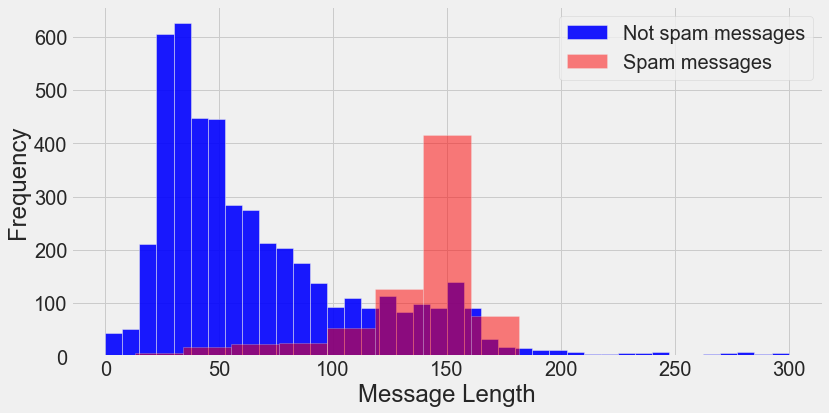

In [7]:

#sms['message_len'] = sms.message.apply(len) sms.head()
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20})
sms[sms.label=='ham'].message_len.plot(bins=40, range=[0, 300],kind='hist', color='blue', 
                                       label='Not spam messages', alpha=0.9)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.5)
plt.legend( prop={'size': 20})
plt.xlabel("Message Length")
plt.savefig('spambarchart.png')
plt.show()

### Calculate the length of messages by labels. For non spam messages 77% are below 100 words. For spam 90% messages above 100 words.

In [8]:
sms[sms['message_len'] <=100].groupby('label')['message_len'].count()

label
ham     3752
spam      76
Name: message_len, dtype: int64

In [9]:
sms[sms['message_len'] > 100].groupby('label')['message_len'].count()

label
ham     1073
spam     671
Name: message_len, dtype: int64

In [10]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure','dun','nah','ok','ltgt']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [11]:
nltk.download('stopwords')
sms['clean_msg'] = sms.message.apply(text_process)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94), ('give', 92), ('say', 91)]


In [13]:
from collections import Counter

words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


In [14]:
# most common text in all the sms

pd.Series(' '.join(sms.clean_msg).lower().split()).value_counts()[:10]

call    576
get     386
go      278
free    275
know    257
like    242
got     238
ill     237
good    234
come    226
dtype: int64

In [15]:
smsNospam = sms[(sms['label'] == 'ham') &sms['clean_msg']]

In [16]:
smsNospam['clean_msg']

0       Go jurong point crazy Available bugis n great ...
1                                      lar Joking wif oni
3                             say early hor c already say
4                      think goes usf lives around though
6          Even brother like speak treat like aids patent
                              ...                        
5565                                              Huh lei
5568                          Ì b going esplanade fr home
5569                          Pity mood Soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       Rofl true name
Name: clean_msg, Length: 4797, dtype: object

In [17]:
# Top 10 common words in no spam sms

pd.Series(' '.join(smsNospam.clean_msg).lower().split()).value_counts()[:10]

get     303
go      247
ill     236
know    232
got     231
call    229
like    229
come    224
good    222
time    189
dtype: int64

In [18]:
smsspam = sms[(sms['label'] == 'spam') &sms['clean_msg']]

In [19]:
smsspam['clean_msg']

2       Free entry wkly comp win FA Cup final tkts 21s...
5       FreeMsg Hey darling 3 weeks word back Id like ...
8       WINNER valued network customer selected receiv...
9       mobile 11 months R entitled Update latest colo...
11      SIX chances win CASH 100 20000 pounds txt CSH1...
                              ...                        
5537    Want explicit SEX 30 secs Ring 02073162414 Cos...
5540    ASKED 3MOBILE 0870 CHATLINES INCLU FREE MINS I...
5547    contract mobile 11 Mnths Latest Motorola Nokia...
5566    REMINDER O2 get 250 pounds free call credit de...
5567    2nd time tried contact å£750 Pound prize claim...
Name: clean_msg, Length: 747, dtype: object

In [20]:
# top 10 spam words in sms

pd.Series(' '.join(smsspam.clean_msg).lower().split()).value_counts()[:10]

call      347
free      216
txt       150
mobile    123
text      120
stop      113
claim     113
reply     101
prize      92
get        83
dtype: int64

In [21]:
# change all text to lowercase
sms.apply(lambda x: x.astype(str).str.lower())

,label,message,label_num,message_len,clean_msg
0,ham,"go until jurong point, crazy.. available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,ok lar... joking wif u oni...,0,29,lar joking wif oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,u dun say so early hor... u c already then say...,0,49,say early hor c already say
4,ham,"nah i don't think he goes to usf, he lives aro...",0,61,think goes usf lives around though
...,...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,1,161,2nd time tried contact å£750 pound prize claim...
5568,ham,will ì_ b going to esplanade fr home?,0,37,ì b going esplanade fr home
5569,ham,"pity, * was in mood for that. so...any other s...",0,57,pity mood soany suggestions
5570,ham,the guy did some bitching but i acted like i'd...,0,125,guy bitching acted like id interested buying s...


In [22]:
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,think goes usf lives around though


In [23]:
# set condition to check for messages
conditionSpam = sms['label'] == "spam"
conditionSpamwords = sms['message_len']>100
conditionNotSpam = sms['label'] == "ham"
conditionNotSpamwords = sms['message_len']<=100

In [24]:
sms1= sms[conditionSpam&conditionSpamwords&sms['clean_msg']]
sms2 = sms[conditionNotSpam&conditionNotSpamwords&sms['clean_msg']]

sms3 = sms1.apply(lambda x: x.astype(str).str.lower())
sms4 = sms2.apply(lambda x: x.astype(str).str.lower())

In [25]:
# check all lowercase after setting conditions. sms3 is for spam words, sms4 is non spam
sms4['clean_msg']

1                                   lar joking wif oni
3                          say early hor c already say
4                   think goes usf lives around though
6       even brother like speak treat like aids patent
14                                         date sunday
                             ...                      
5564                  wait til least wednesday see get
5565                                           huh lei
5568                       ì b going esplanade fr home
5569                       pity mood soany suggestions
5571                                    rofl true name
Name: clean_msg, Length: 3724, dtype: object

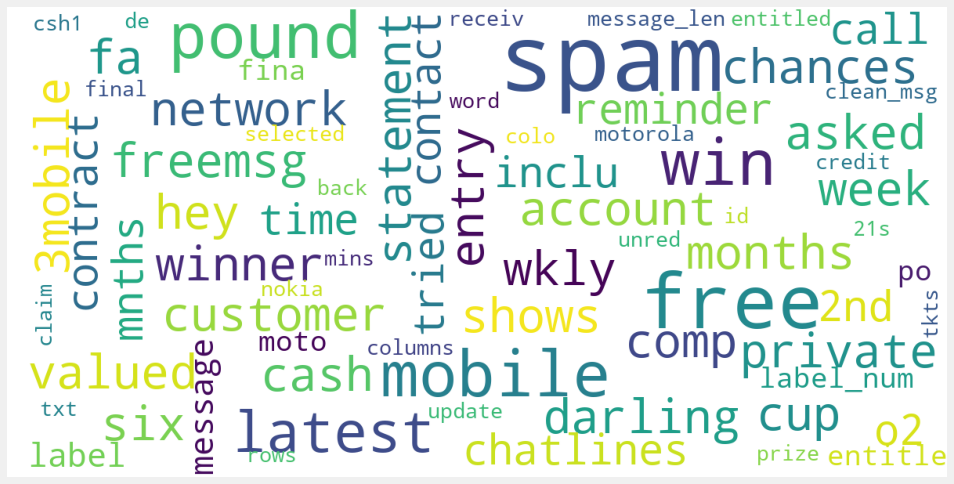

In [26]:
# show wordcloud on messages above 
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(sms3)

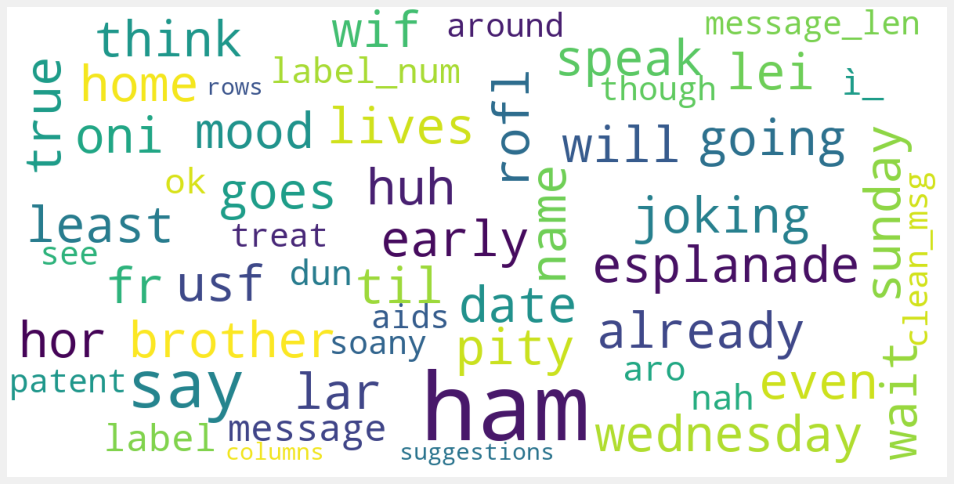

In [27]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(sms4)

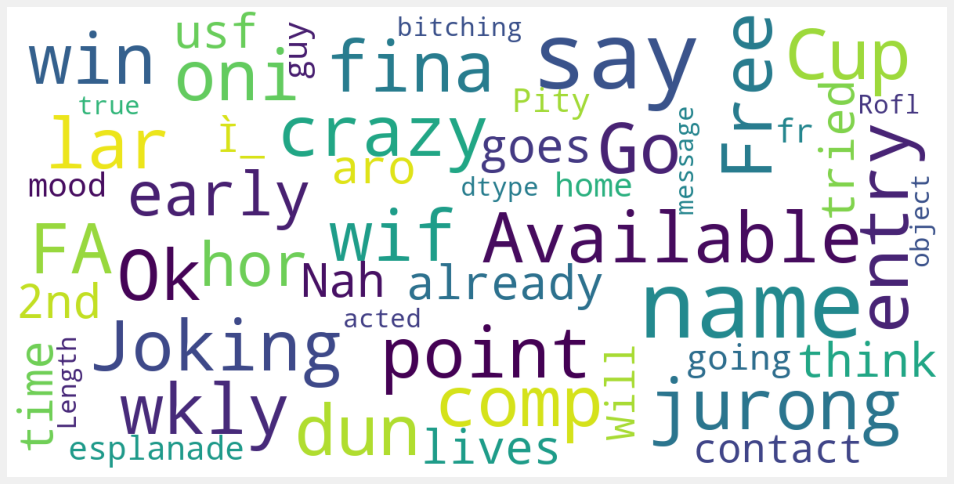

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(sms['message'])

In [29]:
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=400, max_font_size=40, scale=30,
        random_state=1).generate_from_frequencies((sms['message'].value_counts()  ))

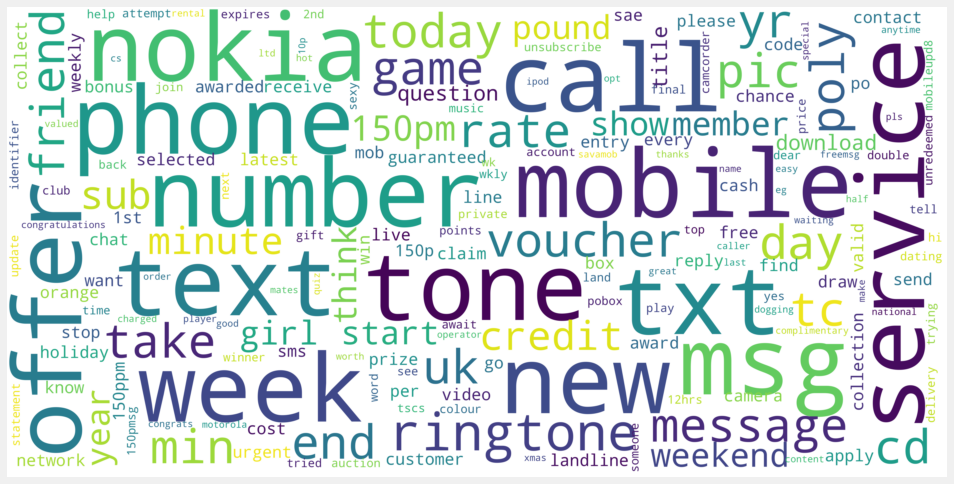

In [30]:
# try to tokenize to individual word (uni-gram) - on spam messages above 100 words
split_title = []
listCounts = []
split_title = [x.split(" ") for x in sms3['clean_msg'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('spamcloud.png')
plt.show()

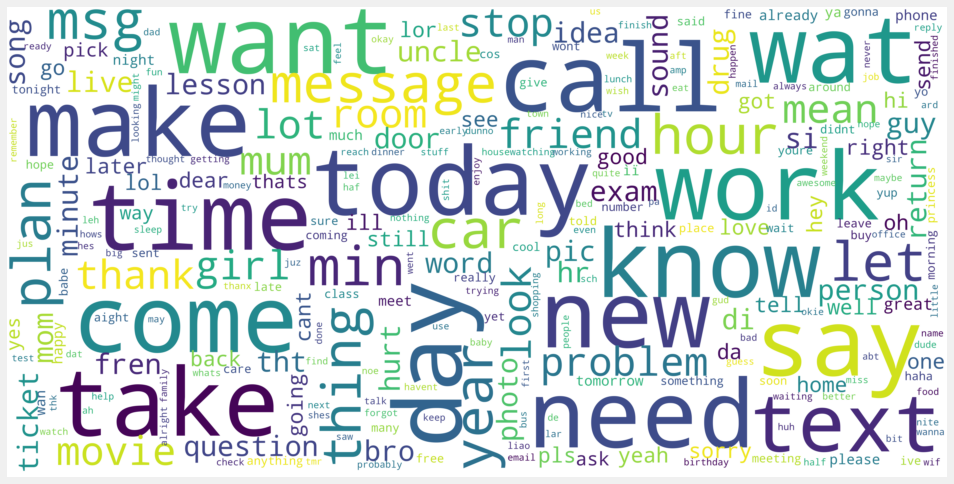

In [31]:
# try to tokenize to individual word (uni-gram) - on not spam messages below 100 words
split_title = []
listCounts = []
split_title = [x.split(" ") for x in sms4['clean_msg'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('nospamcloud.png')
plt.show()

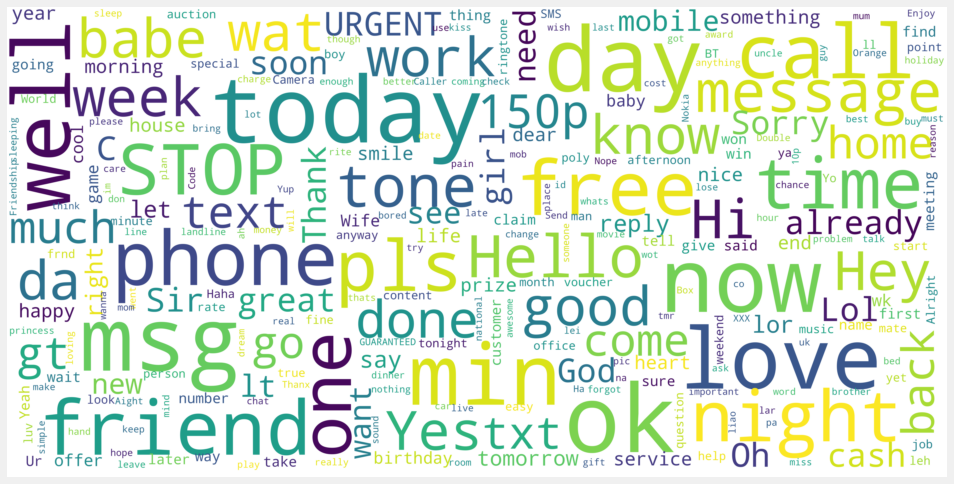

In [32]:
# try to tokenize to individual word (uni-gram) - reviews
split_title = []
listCounts = []
split_title = [x.split(" ") for x in sms['message'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Exploratory Data Analysis (EDA). Tokenise text to get high frequency words

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline 
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import accuracy_score, f1_score

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [34]:
spam_df = sms3[sms3['label'] == 'spam'] #create sub-dataframe of spam text
ham_df = sms4[sms4['label'] == 'ham'] #sub-dataframe of ham text

In [35]:
spam_df

,label,message,label_num,message_len,clean_msg
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
5,spam,freemsg hey there darling it's been 3 week's n...,1,148,freemsg hey darling 3 weeks word back id like ...
8,spam,winner!! as a valued network customer you have...,1,158,winner valued network customer selected receiv...
9,spam,had your mobile 11 months or more? u r entitle...,1,154,mobile 11 months r entitled update latest colo...
11,spam,"six chances to win cash! from 100 to 20,000 po...",1,136,six chances win cash 100 20000 pounds txt csh1...
...,...,...,...,...,...
5526,spam,private! your 2003 account statement for shows...,1,134,private 2003 account statement shows 800 unred...
5540,spam,asked 3mobile if 0870 chatlines inclu in free ...,1,160,asked 3mobile 0870 chatlines inclu free mins i...
5547,spam,had your contract mobile 11 mnths? latest moto...,1,160,contract mobile 11 mnths latest motorola nokia...
5566,spam,reminder from o2: to get 2.50 pounds free call...,1,147,reminder o2 get 250 pounds free call credit de...


In [36]:
stop_words = set(stopwords.words('english'))
def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n]') 
        txt = regex.sub(' ',text)  #remove punctuation
        words = [w for w in txt.split(' ')\
                if not w in stop_words ] # remove stop words and words with length smaller than 3 letters
        return len(words)
    except:
        return 0

In [37]:
spam_df['len'] = spam_df['clean_msg'].apply(lambda x: len([w for w in x.split(' ')]))
ham_df['len'] = ham_df['clean_msg'].apply(lambda x: len([w for w in x.split(' ')]))
spam_df['processed_len'] = spam_df['clean_msg'].apply(lambda x: wordCount(x))
ham_df['processed_len'] = ham_df['clean_msg'].apply(lambda x: wordCount(x))

In [38]:
def tokenize(text):
    exclude = set(string.punctuation)
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]') #remove punctuation
    text = regex.sub(' ', text)
    tokens = nltk.word_tokenize(text) # tokenize the text
    tokens = list(filter(lambda x: x.lower() not in stop_words, tokens)) # remove stop words
    tokens = [w.lower() for w in tokens if len(w) >=3] 
    tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
    return tokens

In [39]:
spam_df['tokens'] = spam_df['clean_msg'].map(tokenize)
ham_df['tokens'] = ham_df['clean_msg'].map(tokenize)

In [40]:
spam_words = []
for token in spam_df['tokens']:
    spam_words = spam_words + token #combine text in different columns in one list
ham_words = []
for token in ham_df['tokens']:
    ham_words = ham_words + token

In [41]:
spam_count = Counter(spam_words).most_common(10)
ham_count = Counter(ham_words).most_common(10)

In [42]:
spam_count_df = pd.DataFrame(spam_count, columns = ['word', 'count'])
ham_count_df = pd.DataFrame(ham_count, columns = ['word', 'count'])

In [43]:
# checking output against dataframe. sms4 is no spam top 10 words
pd.Series(' '.join(sms4.clean_msg).lower().split()).value_counts()[:10]

get      182
ill      178
call     176
come     164
got      139
go       136
like     133
going    121
good     119
lor      117
dtype: int64

In [44]:
ham_count_df

,word,count
0,get,184
1,ill,178
2,call,176
3,come,164
4,got,149
5,like,133
6,going,121
7,good,119
8,lor,117
9,time,117


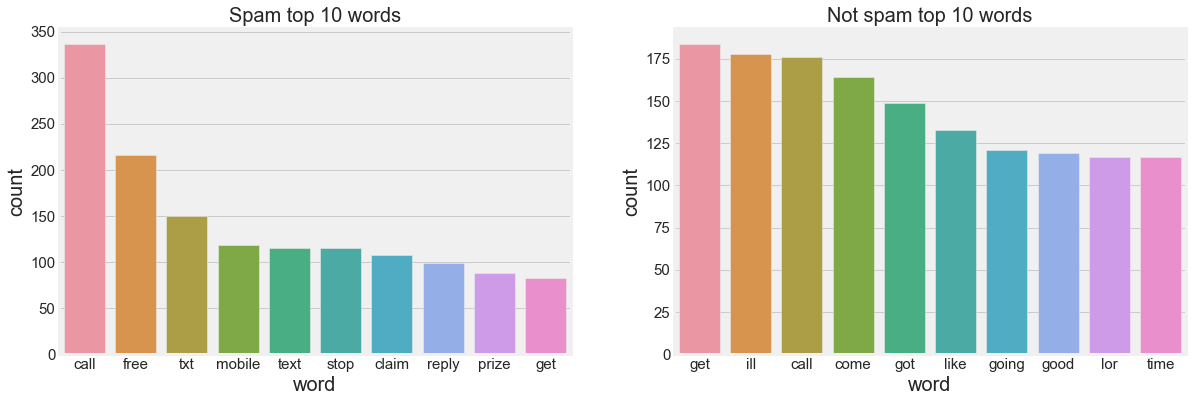

In [45]:
spam_count
fig, (ax,ax1) = plt.subplots(1,2,figsize = (18, 6))
sns.barplot(x = spam_count_df['word'], y = spam_count_df['count'], ax = ax)
ax.set_ylabel('count', fontsize = 20)
ax.set_xlabel('word',fontsize = 20)
ax.tick_params(labelsize=15)
ax.set_title('Spam top 10 words', fontsize = 20)
sns.barplot(x = ham_count_df['word'], y = ham_count_df['count'], ax = ax1)
ax1.set_ylabel('count', fontsize = 20)
ax1.set_xlabel('word',fontsize = 20)
ax1.tick_params(labelsize=15)
ax1.set_title('Not spam top 10 words', fontsize = 20)
plt.savefig('topwords.png')
plt.show()

In [46]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94), ('give', 92), ('say', 91)]


In [47]:
sms3.head()

,label,message,label_num,message_len,clean_msg
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
5,spam,freemsg hey there darling it's been 3 week's n...,1,148,freemsg hey darling 3 weeks word back id like ...
8,spam,winner!! as a valued network customer you have...,1,158,winner valued network customer selected receiv...
9,spam,had your mobile 11 months or more? u r entitle...,1,154,mobile 11 months r entitled update latest colo...
11,spam,"six chances to win cash! from 100 to 20,000 po...",1,136,six chances win cash 100 20000 pounds txt csh1...


In [48]:
from collections import Counter

words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


In [49]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

sms['message'] = sms.message.map(alphanumeric).map(punc_lower)
sms.tail()

,label,message,label_num,message_len,clean_msg
5567,spam,this is the time we have tried contact u ...,1,161,2nd time tried contact å£750 Pound prize claim...
5568,ham,will ì b going to esplanade fr home,0,37,Ì b going esplanade fr home
5569,ham,pity was in mood for that so any other s...,0,57,Pity mood Soany suggestions
5570,ham,the guy did some bitching but i acted like i d...,0,125,guy bitching acted like id interested buying s...
5571,ham,rofl its true to its name,0,26,Rofl true name


In [50]:
sms['label1'] = sms.label.map({'ham':'nospam', 'spam':'spam'})
sms.head()

,label,message,label_num,message_len,clean_msg,label1
0,ham,go until jurong point crazy available only ...,0,111,Go jurong point crazy Available bugis n great ...,nospam
1,ham,ok lar joking wif u oni,0,29,lar Joking wif oni,nospam
2,spam,free entry in a wkly comp to win fa cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...,spam
3,ham,u dun say so early hor u c already then say,0,49,say early hor c already say,nospam
4,ham,nah i don t think he goes to usf he lives aro...,0,61,think goes usf lives around though,nospam


In [51]:
# Split the data into X and y data sets
X = sms.message
y = sms.label1

In [52]:
X.head()

0    go until jurong point  crazy   available only ...
1                        ok lar    joking wif u oni   
2    free entry in   a wkly comp to win fa cup fina...
3    u dun say so early hor    u c already then say   
4    nah i don t think he goes to usf  he lives aro...
Name: message, dtype: object

In [53]:
y.head()

0    nospam
1    nospam
2      spam
3    nospam
4    nospam
Name: label1, dtype: object

In [54]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
y_test

3245    nospam
944     nospam
1044      spam
2484    nospam
812       spam
         ...  
2505    nospam
2525    nospam
4975    nospam
650     nospam
4463    nospam
Name: label1, Length: 1672, dtype: object

In [56]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,aa,aah,aaooooright,aathi,ab,abbey,abeg,abel,aberdeen,abi,...,åð,åôrents,ìï,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,aa,aa exhaust,aah,aah bless,aah cuddle,aah speak,aaooooright,aaooooright work,aathi,aathi love,...,ûªve bin,ûï,ûïharry,ûïharry potter,ûò,ûò address,ûò favour,ûò limping,ûówell,ûówell yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [59]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [60]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [61]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

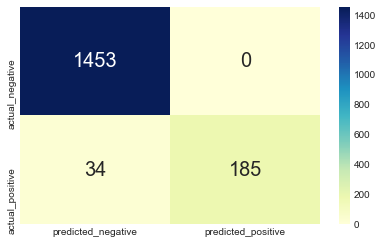

In [62]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

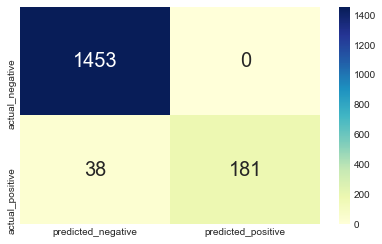

In [63]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [64]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.980,0.977
Precision,1.000,1.000
Recall,0.845,0.826
F1 Score,0.916,0.905


In [65]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [66]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

In [67]:
y_train.shape

(3900,)

In [68]:
X_train_cv1.shape

(3900, 6033)

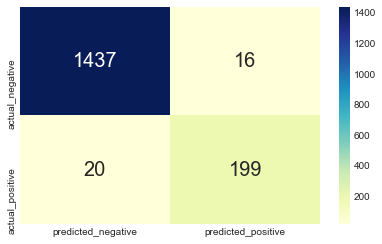

In [69]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

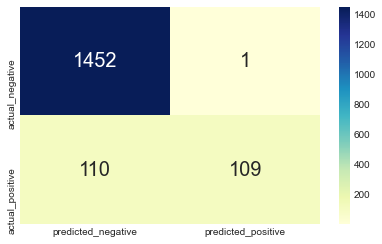

In [70]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [71]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.980,0.977,0.978,0.934
Precision,1.000,1.000,0.926,0.991
Recall,0.845,0.826,0.909,0.498
F1 Score,0.916,0.905,0.917,0.663


In [72]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [73]:
X_test_tfidf1.shape

(1672, 6033)

In [74]:
y_train.shape

(3900,)

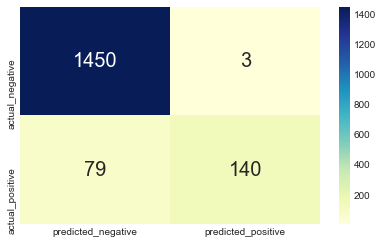

In [75]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

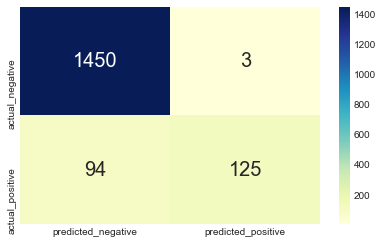

In [76]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

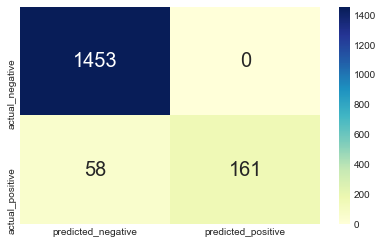

In [77]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

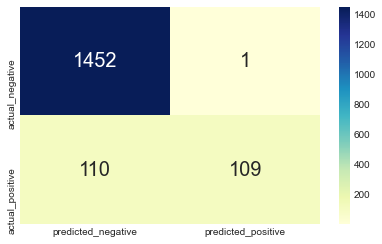

In [78]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [79]:
X_train_tfidf2.toarray().shape

(3900, 25937)

In [80]:
y_train.shape

(3900,)

In [81]:
X_train_tfidf1.toarray().shape

(3900, 6033)

In [82]:
y_train.shape

(3900,)

In [83]:
from sklearn import metrics, svm
clf = svm.LinearSVC(loss='hinge')

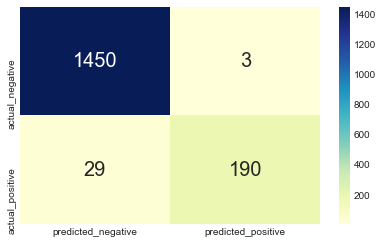

In [85]:
# Fit the first logistic regression on the TF-IDF data
clf.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_clf = clf.predict(X_test_tfidf1)
cm9 = conf_matrix(y_test, y_pred_tfidf1_clf)

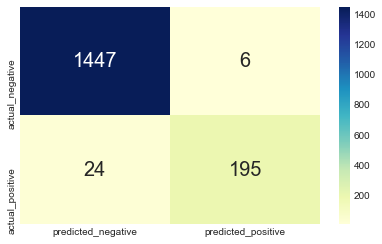

In [86]:
# Fit the first logistic regression on the TF-IDF data



clf.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_clf = clf.predict(X_test_tfidf2)
cm10 = conf_matrix(y_test, y_pred_tfidf2_clf)

In [87]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8, cm9, cm10)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF','SVM1-TFIDF','SVM2-TFIDF']
results_tf

results = pd.concat([ results_tf], axis=1)
results

,LR1-TFIDF,LR2-TFIDF,NB1-TFIDF,NB2-TFIDF,SVM1-TFIDF,SVM2-TFIDF
Accuracy,0.951,0.942,0.965,0.934,0.981,0.982
Precision,0.979,0.977,1.000,0.991,0.984,0.970
Recall,0.639,0.571,0.735,0.498,0.868,0.890
F1 Score,0.773,0.721,0.847,0.663,0.922,0.928


## Neural Network

In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras import metrics

In [89]:
tags = sms["label"]
texts = sms["message"]

In [90]:
## For enumeration up to a maximum of 1000
num_max = 1000

## Tags make 0 and 1
le = LabelEncoder()
tags = le.fit_transform(tags)

## The process of enumerating words
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(texts)

# Number of word counts
#print(tok.word_docs)

In [91]:
# For example, how to enumerate words
print(texts[1])
print(tok.word_index['ok'],tok.word_index['lar'],tok.word_index['joking'],tok.word_index['wif'],tok.word_index['u'],tok.word_index['oni'])

ok lar    joking wif u oni   
48 325 1374 444 6 1768


In [92]:
## A maximum of 100 words and sentences are maintained
max_len = 100
cnn_texts_seq = tok.texts_to_sequences(texts)
for i in range(len(cnn_texts_seq)):
    if(len(cnn_texts_seq[i])>100):
        print('Word Counts:', len(cnn_texts_seq[i]),'Indexes:',i)


Word Counts: 173 Indexes: 1084
Word Counts: 156 Indexes: 1862
Word Counts: 102 Indexes: 2157
Word Counts: 102 Indexes: 2847


In [93]:
## A maximum of 100 words and sentences are maintained
## The number of words is made from 100. Missing words are written to 0.

cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)

## There are 30 words in the second sentence.
## All words are indexed
## The most used 1000 words are taken.
## Less used words are removed.
## If the number of words is less than 100, 0 is added. 
## If the number of words is greater than 100 is deleted
print('***************************************************')
print(texts[2])
print(cnn_texts_mat[2])
print('***************************************************')


***************************************************
free entry in   a wkly comp to win fa cup final tkts   may    text fa to   to receive entry question std txt rate t c s apply   s
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  50 460   8   4 741 833   2 181 619 257  73   2   2 326
 460 524 884  75 373  25 119  19 374  19]
***************************************************


In [94]:
cnn_texts_mat.shape

(5572, 100)

In [95]:
## Number of words 101
## The word sad has been deleted.
## There are 100 words left.
print('***************************************************')
print(texts[2157])
print('***************************************************')
print(cnn_texts_mat[2157])
print('***************************************************')

print('sad index:',tok.word_index['sad'], 'story index:',tok.word_index['story'])


***************************************************
sad story of a man   last week was my b day  my wife did nt wish me  my parents forgot n so did my kids   i went to work  even my colleagues did not wish  as i entered my cabin my pa said     happy b day boss       i felt special  she askd me   lunch  after lunch she invited me to her apartment  we went there  she said    do u mind if i go into the bedroom for a minute        ok    i sed in a sexy mood  she came out   minuts latr wid a cake   n my wife  my parents  my kidz  my friends n my colleagues  all screaming   surprise    and i was waiting on the sofa               naked    
***************************************************
[ 15   4 275 176 113  62  11 167  64  11 430 111 556 248  10  11 652 381
  92  24 111  11 999   1 212   2 144 206  11 111  27 248  74   1 899  11
  11 367 161 138 167  64   1 792 254  82 847  10 273 157 273  82 793  10
   2 106  32 212  61  82 161  30   6 308  35   1  52 347   5  13   4 604
  48   1   8   

In [96]:
model = Sequential()
model.add(Embedding(1000,20,input_length=max_len))
model.add(Dropout(0.2))
model.add(Conv1D(64,5,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 20)           20000     
_________________________________________________________________
dropout (Dropout)            (None, 100, 20)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            6464      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [97]:
history=model.fit(cnn_texts_mat,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
140/140 [==============================] - 1s 6ms/step - loss: 0.3768 - acc: 0.8627 - val_loss: 0.2105 - val_acc: 0.9193
Epoch 2/10
140/140 [==============================] - 1s 5ms/step - loss: 0.1029 - acc: 0.9672 - val_loss: 0.0533 - val_acc: 0.9812
Epoch 3/10
140/140 [==============================] - 1s 4ms/step - loss: 0.0524 - acc: 0.9847 - val_loss: 0.0476 - val_acc: 0.9865
Epoch 4/10
140/140 [==============================] - 1s 4ms/step - loss: 0.0448 - acc: 0.9870 - val_loss: 0.0415 - val_acc: 0.9865
Epoch 5/10
140/140 [==============================] - 1s 4ms/step - loss: 0.0384 - acc: 0.9895 - val_loss: 0.0462 - val_acc: 0.9857
Epoch 6/10
140/140 [==============================] - 1s 4ms/step - loss: 0.0336 - acc: 0.9912 - val_loss: 0.0463 - val_acc: 0.9883
Epoch 7/10
140/140 [==============================] - 1s 4ms/step - loss: 0.0275 - acc: 0.9919 - val_loss: 0.0452 - val_acc: 0.9865
Epoch 8/10
140/140 [==============================] - 1s 4ms/step - loss: 0.

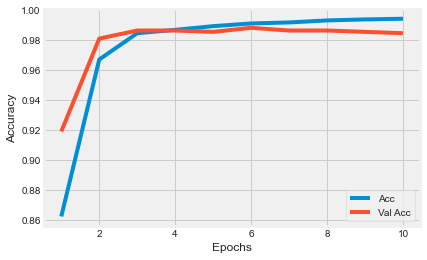

In [98]:
import matplotlib.pyplot as plt
epochs = range(1, 11)
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, '-', label='Acc')
plt.plot(epochs, val_acc, '-', label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

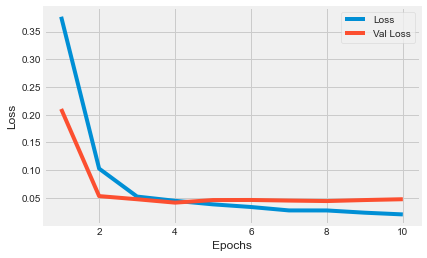

In [99]:
import matplotlib.pyplot as plt
epochs = range(1, 11)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, '-', label='Loss')
plt.plot(epochs, val_loss, '-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

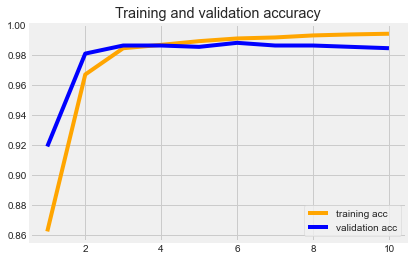

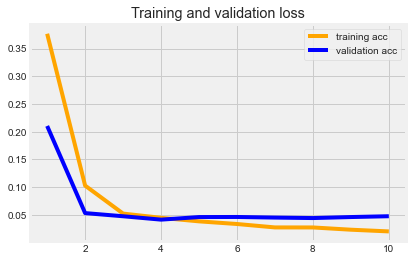

In [100]:
epochs = range(1, 11)
acc = history.history['acc']
val_acc = history.history['val_acc']


plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

epochs = range(1, 11)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Testing the data

In [101]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, svm
from sklearn.model_selection import (
    train_test_split, learning_curve, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score)

# Improve the readability of figures
sns.set_context('notebook', font_scale=1.4)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [102]:
y= sms['label']

In [103]:
y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: label, Length: 5572, dtype: object

In [104]:
# Encode the class labels as numbers
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [105]:
# Store the SMS message data
raw_text = sms['message']

In [106]:
sms['message']

0       go until jurong point  crazy   available only ...
1                           ok lar    joking wif u oni   
2       free entry in   a wkly comp to win fa cup fina...
3       u dun say so early hor    u c already then say   
4       nah i don t think he goes to usf  he lives aro...
                              ...                        
5567    this is the   time we have tried   contact u  ...
5568                will ì  b going to esplanade fr home 
5569    pity    was in mood for that  so   any other s...
5570    the guy did some bitching but i acted like i d...
5571                           rofl  its true to its name
Name: message, Length: 5572, dtype: object

In [107]:
# Replace email addresses with 'emailaddr'
processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')

# Replace URLs with 'httpaddr'
processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')

# Replace money symbols with 'moneysymb'
processed = processed.str.replace(r'£|\$', '$')
    
# Replace phone numbers with 'phonenumbr'
processed = processed.str.replace(
    r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
    'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

In [108]:
# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [109]:
# Lowercase the corpus
processed = processed.str.lower()

In [110]:
# Access stop words
stop_words = nltk.corpus.stopwords.words('english')

In [111]:
# Remove all stop words
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words))
)

In [112]:
# Remove word stems using a Porter stemmer
porter = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(
    porter.stem(term) for term in x.split())
)

In [113]:
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', '$', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

In [114]:
(processed == raw_text.apply(preprocess_text)).all()

True

In [115]:
# Construct a design matrix using an n-gram model and a tf-idf statistics
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(processed)

In [116]:
X_ngrams.shape

(5572, 34866)

In [117]:
y_enc.shape

(5572,)

In [118]:
# Prepare the training and test sets using an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_ngrams,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

# Train SVM with a linear kernel on the training set
clf = svm.LinearSVC(loss='hinge')
clf.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test)

# Compute the F1 score
metrics.f1_score(y_test, y_pred)

0.9090909090909092

In [119]:
y_enc

array([0, 0, 1, ..., 0, 0, 0])

In [120]:
# Display a confusion matrix
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

predicted     
                 spam  ham
actual spam       965    1
       ham         24  125

In [121]:
# Select 10 different sizes of the entire dataset
sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')

# Compute learning curves without regularization for the SVM model
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svm.LinearSVC(loss='hinge', C=1e10),
    X=X_ngrams,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),
    scoring='f1',
    n_jobs=-1
)

In [122]:
def make_tidy(sample_space, train_scores, valid_scores):
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    # Re-structure into into tidy format
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='F1 score'
    )

C:\Users\igung\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


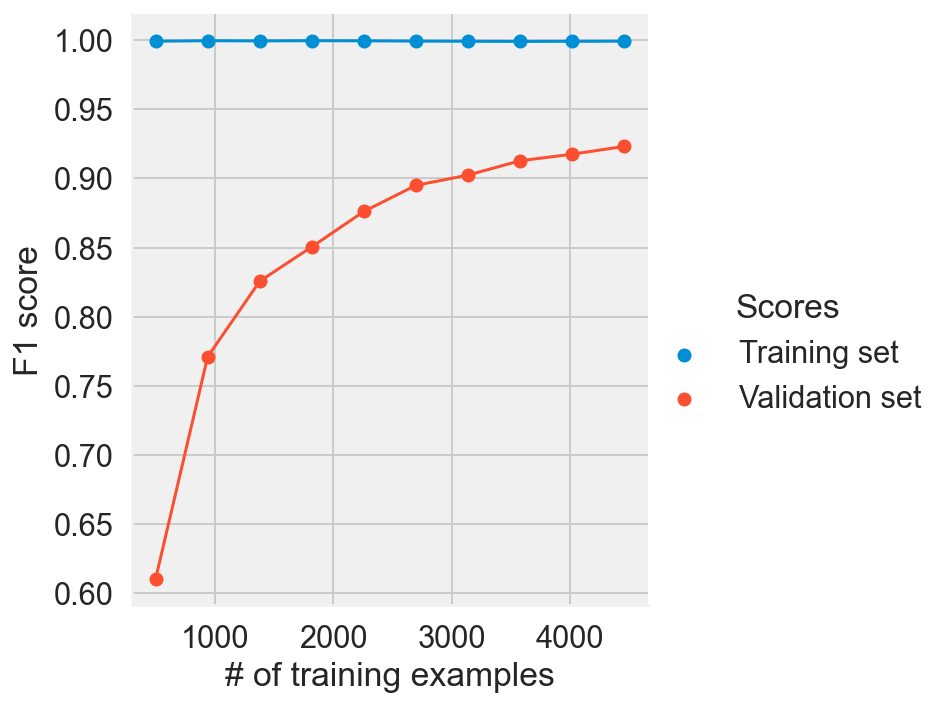

In [123]:
# Initialize a FacetGrid object using the table of scores and facet on
# the type of score
g = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

# Plot the learning curves and add a legend
g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend();

In [124]:
# Select a range of values to test the regularization hyperparameter
param_grid = [{'C': np.logspace(-4, 4, 20)}]

# Inner cross-validation loop to tune the hyperparameter
grid_search = GridSearchCV(
    estimator=svm.LinearSVC(loss='hinge'),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

# Outer cross-validation loop to assess the model's performance
scores = cross_val_score(
    estimator=grid_search,
    X=X_ngrams,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    scoring='f1',
    n_jobs=-1
)

scores

array([0.91304348, 0.90909091, 0.9057971 , 0.91696751, 0.95104895,
       0.91696751, 0.92086331, 0.92028986, 0.93617021, 0.91756272])

In [125]:
scores.mean()

0.9207801559105823

In [126]:
# Identify the optimal regularization hyperparameter
grid_search.fit(X_ngrams, y_enc)

# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, y_enc);

C:\Users\igung\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [127]:
X_ngrams.shape

(5572, 34866)

In [128]:
y_enc.shape

(5572,)

In [129]:
final_clf.coef_.T.ravel().shape

(34866,)

## Testing the SVM model with sample sms messages

In [130]:
# Display the features with the highest weights in the SVM model
pd.Series(
    final_clf.coef_.T.ravel(),
    index=vectorizer.get_feature_names()
).sort_values(ascending=False)[:20]

txt          3.312331
claim        2.789141
uk           2.652535
servic       2.596012
mobil        2.442390
www          2.109667
rington      1.935206
tone         1.921874
prize        1.919431
ringtonek    1.869048
cost         1.864080
repli        1.862696
text         1.838711
video        1.774130
lost help    1.772711
com          1.755865
award        1.671518
let talk     1.516315
co uk        1.501113
talk time    1.463142
dtype: float64

In [131]:
def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'spam'
    else:
        return 'not spam'

In [132]:
spam_filter('I am going to metis for data science lesson')

'not spam'

In [133]:
spam_filter('If you want low interest on your loan call this number')

'not spam'

### Appendix

## RNN recurrent neural network

In [134]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [135]:
data =  pd.read_csv("C:/Users/igung/kaplan/project 4 spam messages/spam.csv", encoding='latin-1')
data.dropna(how="any", inplace=True, axis=1)
data.columns = ['label', 'message']
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [136]:
texts = []
labels = []
for i, label in enumerate(data['label']):
    texts.append(data['message'][i])
    if label == 'ham':
        labels.append(0)
    else:
        labels.append(1)

texts = np.asarray(texts)
labels = np.asarray(labels)

In [137]:
print("number of texts :" , len(texts))
print("number of labels: ", len(labels))

number of texts : 5572
number of labels:  5572


In [138]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# number of words used as features
max_features = 10000
# cut off the words after seeing 500 words in each document(email)
maxlen = 500


# we will use 80% of data as training, 20% as validation data
training_samples = int(5572 * .8)
validation_samples = int(5572 - training_samples)
# sanity check
print(len(texts) == (training_samples + validation_samples))
print("The number of training {0}, validation {1} ".format(training_samples, validation_samples))


tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found {0} unique words: ".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

print("data shape: ", data.shape)

np.random.seed(42)
# shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


texts_train = data[:training_samples]
y_train = labels[:training_samples]
texts_test = data[training_samples:]
y_test = labels[training_samples:]

True
The number of training 4457, validation 1115 
Found 8920 unique words: 
data shape:  (5572, 500)


In [139]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_rnn = model.fit(texts_train, y_train, epochs=10, batch_size=20, validation_split=0.2)

Epoch 1/10
179/179 [==============================] - 11s 64ms/step - loss: 0.2342 - acc: 0.9237 - val_loss: 0.0839 - val_acc: 0.9821
Epoch 2/10
179/179 [==============================] - 12s 67ms/step - loss: 0.0863 - acc: 0.9717 - val_loss: 0.1627 - val_acc: 0.9496
Epoch 3/10
179/179 [==============================] - 13s 75ms/step - loss: 0.0554 - acc: 0.9829 - val_loss: 0.0513 - val_acc: 0.9865
Epoch 4/10
179/179 [==============================] - 12s 68ms/step - loss: 0.0660 - acc: 0.9787 - val_loss: 0.0966 - val_acc: 0.9596
Epoch 5/10
179/179 [==============================] - 15s 82ms/step - loss: 0.0372 - acc: 0.9893 - val_loss: 0.0508 - val_acc: 0.9865
Epoch 6/10
179/179 [==============================] - 15s 81ms/step - loss: 0.0488 - acc: 0.9840 - val_loss: 0.0723 - val_acc: 0.9776
Epoch 7/10
179/179 [==============================] - 12s 67ms/step - loss: 0.0270 - acc: 0.9935 - val_loss: 0.0652 - val_acc: 0.9809
Epoch 8/10
179/179 [==============================] - 11s 64ms

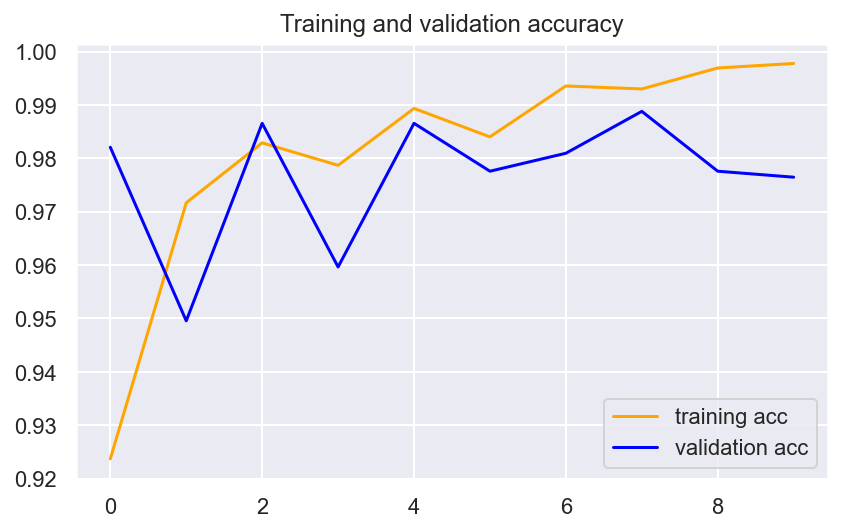

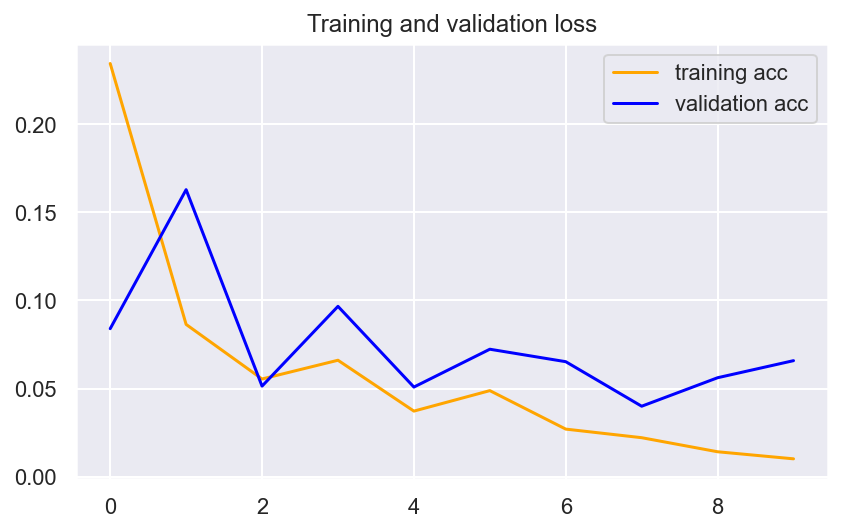

In [140]:
acc = history_rnn.history['acc']
val_acc = history_rnn.history['val_acc']
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [141]:
pred = model.predict_classes(texts_test)
acc = model.evaluate(texts_test, y_test)
proba_rnn = model.predict_proba(texts_test)
from sklearn.metrics import confusion_matrix
print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
print(confusion_matrix(pred, y_test))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
35/35 [==============================] - 0s 14ms/step - loss: 0.0982 - acc: 0.9722
Instructions for updating:
Please use `model.predict()` instead.
Test loss is 0.10 accuracy is 0.97  
[[946  19]
 [ 12 138]]


In [ ]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_ltsm = model.fit(texts_train, y_train, epochs=10, batch_size=20, validation_split=0.2)

Epoch 1/10
179/179 [==============================] - 20s 110ms/step - loss: 0.2036 - acc: 0.9346 - val_loss: 0.0655 - val_acc: 0.9832
Epoch 2/10
179/179 [==============================] - 24s 135ms/step - loss: 0.0562 - acc: 0.9846 - val_loss: 0.0490 - val_acc: 0.9843
Epoch 3/10
179/179 [==============================] - 24s 136ms/step - loss: 0.0357 - acc: 0.9896 - val_loss: 0.0362 - val_acc: 0.9899
Epoch 4/10
179/179 [==============================] - 24s 134ms/step - loss: 0.0245 - acc: 0.9921 - val_loss: 0.0425 - val_acc: 0.9854
Epoch 5/10
179/179 [==============================] - 26s 143ms/step - loss: 0.0193 - acc: 0.9947 - val_loss: 0.0417 - val_acc: 0.9888
Epoch 6/10
 45/179 [======>.......................] - ETA: 17s - loss: 0.0151 - acc: 0.9967

In [ ]:
acc = history_ltsm.history['acc']
val_acc = history_ltsm.history['val_acc']
loss = history_ltsm.history['loss']
val_loss = history_ltsm.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim(0.9, 1)
plt.savefig('training&validation1.png')
plt.show()


plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('training&validation2.png')
plt.show()


In [ ]:
pred = model.predict_classes(texts_test)
acc = model.evaluate(texts_test, y_test)
proba_ltsm = model.predict_proba(texts_test)
from sklearn.metrics import confusion_matrix
print("Test loss is {0:.2f} accuracy is {1:.2f}  ".format(acc[0],acc[1]))
print(confusion_matrix(pred, y_test))

In [ ]:
cm11 = conf_matrix(y_test,pred)

In [ ]:
 f1_score(y_test,pred)